In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from re import L
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score

In [21]:
# Load the dataset
df = pd.read_csv('E:\Drive\Drilling\PZ-132.csv')
df.head()

,ROP,WOB,rpm_bit,mudweight_in,mudweight_out,P ovb For Soft formation,P ovb For Hard formation,P ovb,d,D-Adjust,PP Zamora Method,PP Eaton Method
0,0.04,3.6,66,79.47,79.47,0.903,0.938,0.921,0.81,0.81,8.67,7.73
1,0.03,6.1,66,67.81,67.81,0.902,0.937,0.919,0.85,0.85,8.67,7.73
2,0.01,5.9,66,65.68,67.38,0.900,0.936,0.918,0.93,0.91,8.45,7.98
3,0.01,6.6,66,64.07,67.38,0.899,0.935,0.917,0.94,0.89,8.24,8.22
4,0.02,7.5,66,61.55,67.38,0.898,0.934,0.916,0.91,0.83,7.92,8.62


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705 entries, 0 to 2704
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ROP                       2705 non-null   float64
 1   WOB                       2705 non-null   float64
 2   rpm_bit                   2705 non-null   int64  
 3   mudweight_in              2705 non-null   float64
 4   mudweight_out             2705 non-null   float64
 5   P ovb For Soft formation  2705 non-null   float64
 6   P ovb For Hard formation  2705 non-null   float64
 7   P ovb                     2705 non-null   float64
 8   d                         2705 non-null   float64
 9   D-Adjust                  2705 non-null   float64
 10  PP Zamora Method          2705 non-null   float64
 11  PP Eaton Method           2705 non-null   object 
dtypes: float64(10), int64(1), object(1)
memory usage: 253.7+ KB


In [22]:
# Drop unnecessary features
df = df.drop(
    ['P ovb For Soft formation', 'P ovb For Hard formation', 'P ovb', 'd', 'D-Adjust',
     'PP Eaton Method'], axis=1
)
df = df.drop(0, axis=0)
df = df.reset_index(drop=True)
df.head()

,ROP,WOB,rpm_bit,mudweight_in,mudweight_out,PP Zamora Method
0,0.03,6.1,66,67.81,67.81,8.67
1,0.01,5.9,66,65.68,67.38,8.45
2,0.01,6.6,66,64.07,67.38,8.24
3,0.02,7.5,66,61.55,67.38,7.92
4,0.02,7.5,66,58.77,67.38,7.56


In [23]:
df = df.dropna()

In [24]:
print(df.isnull().sum())

ROP                 0
WOB                 0
rpm_bit             0
mudweight_in        0
mudweight_out       0
PP Zamora Method    0
dtype: int64


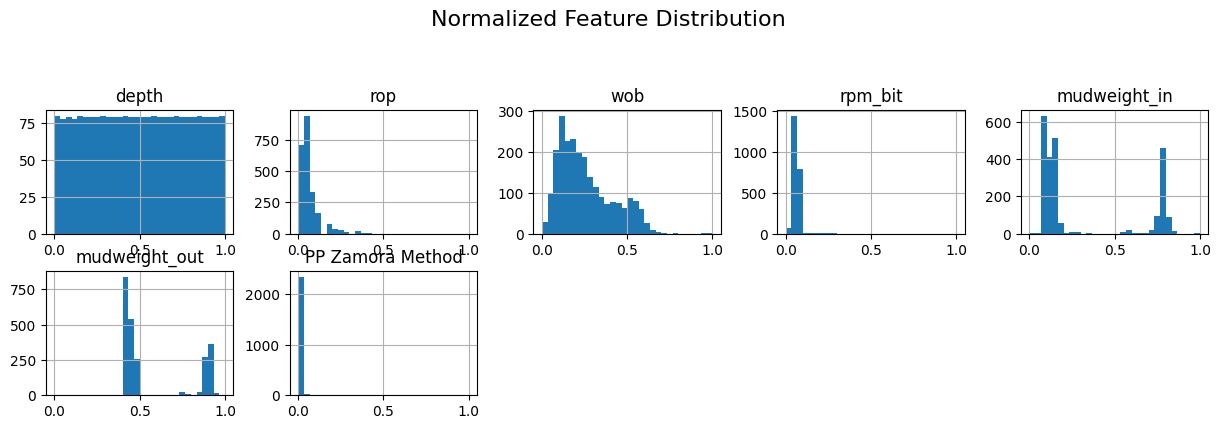

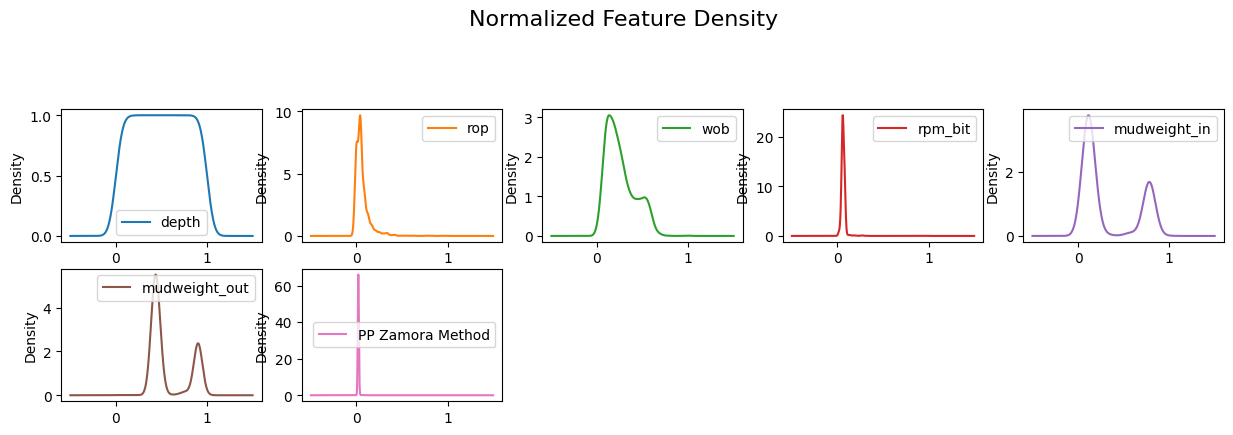

In [50]:
# Plot histograms for normalized data

df_normalized = (df - df.min()) / (df.max() - df.min())  # Min-max normalization

df_normalized.hist(figsize=(15, 10), bins=30, layout=(5, 5))
plt.suptitle("Normalized Feature Distribution", fontsize=16)
plt.show()

# Alternatively, density plot
df_normalized.plot(kind='density', subplots=True, layout=(5, 5), figsize=(15, 10), sharex=False)
plt.suptitle("Normalized Feature Density", fontsize=16)
plt.show()


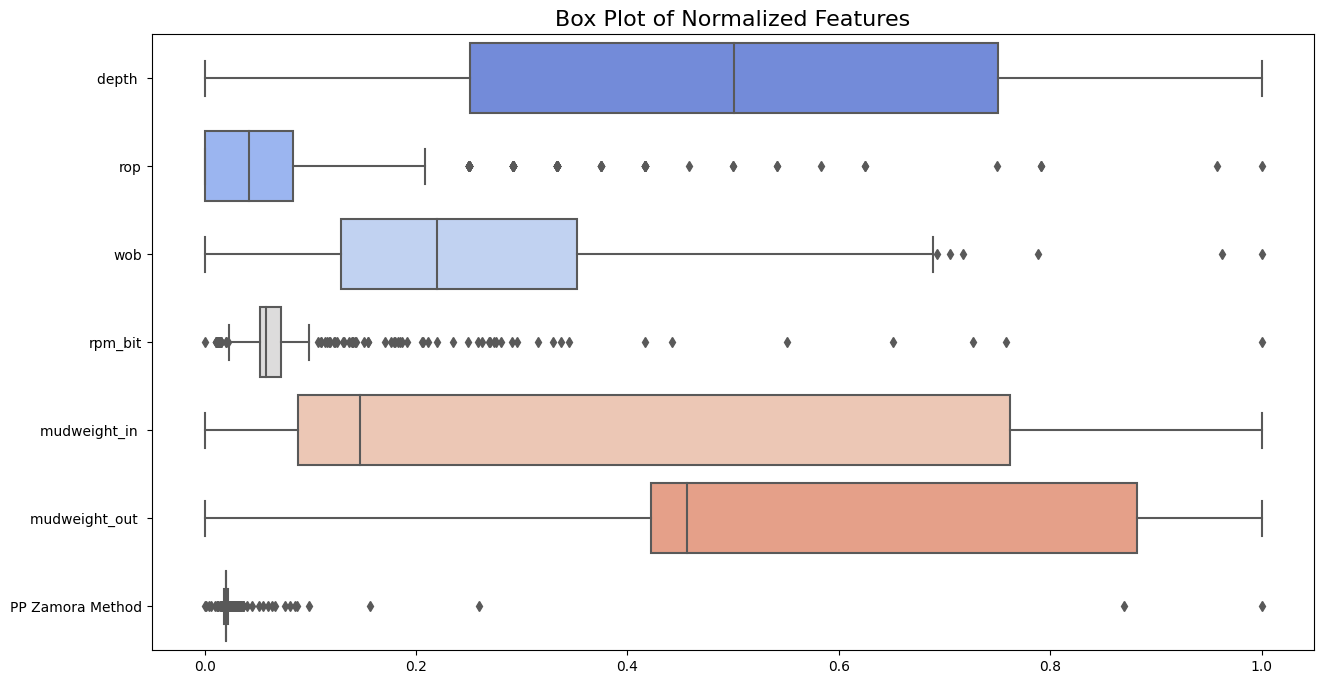

In [36]:
# Box Plot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_normalized, orient='h', palette="coolwarm")
plt.title("Box Plot of Normalized Features", fontsize=16)
plt.show()


In [26]:
# Separate features and target
X = df.drop('PP Zamora Method', axis=1)
y = df['PP Zamora Method']

# Transformation to Reduce Skewness - Apply log(1+x) transformation to reduce skewness
df_transformed = df.copy()
for col in df_transformed.columns:
    df_transformed[col] = np.log1p(df_transformed[col])

X_transformed = df_transformed.drop('PP Zamora Method', axis=1)

# Train/test split on transformed data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

# Robust Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("\nBaseline Linear Regression (With Transformation and Scaling):")
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train R2 Score:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test R2 Score:", r2_score(y_test, y_test_pred))

# Ridge Regression (To Handle Outliers and Reduce Overfitting)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_train_pred_ridge = ridge.predict(X_train_scaled)
y_test_pred_ridge = ridge.predict(X_test_scaled)

print("\nRidge Regression:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_ridge))
print("Train R2 Score:", r2_score(y_train, y_train_pred_ridge))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_ridge))
print("Test R2 Score:", r2_score(y_test, y_test_pred_ridge))

# Random Forest Regressor (Handling Nonlinear Relationships and Outliers)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

print("\nRandom Forest Regressor:")
print("Train MSE:", mean_squared_error(y_train, y_train_pred_rf))
print("Train R2 Score:", r2_score(y_train, y_train_pred_rf))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_rf))
print("Test R2 Score:", r2_score(y_test, y_test_pred_rf))

# Check for Overfitting and Underfitting - Calculate performance gaps between train and test sets
lr_train_test_gap = r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred)
ridge_train_test_gap = r2_score(y_train, y_train_pred_ridge) - r2_score(y_test, y_test_pred_ridge)
rf_train_test_gap = r2_score(y_train, y_train_pred_rf) - r2_score(y_test, y_test_pred_rf)

print("\nOverfitting/Underfitting Analysis:")
print(f"Linear Regression Train-Test R2 Gap: {lr_train_test_gap:.4f}")
print(f"Ridge Regression Train-Test R2 Gap: {ridge_train_test_gap:.4f}")
print(f"Random Forest Train-Test R2 Gap: {rf_train_test_gap:.4f}")



Baseline Linear Regression (With Transformation and Scaling):
Train MSE: 0.048177572101597434
Train R2 Score: 0.9452837633685566
Test MSE: 0.0883909462690662
Test R2 Score: 0.8865257500410954

Ridge Regression:
Train MSE: 0.04817959319306487
Train R2 Score: 0.9452814679743687
Test MSE: 0.08803488536662225
Test R2 Score: 0.8869828527823821

Random Forest Regressor:
Train MSE: 0.008602587111111212
Train R2 Score: 0.9902298689726093
Test MSE: 0.12259661286066591
Test R2 Score: 0.8426133073683947

Overfitting/Underfitting Analysis:
Linear Regression Train-Test R2 Gap: 0.0588
Ridge Regression Train-Test R2 Gap: 0.0583
Random Forest Train-Test R2 Gap: 0.1476


In [18]:
print(np.isnan(X_train_scaled).sum())  # Check for NaNs in the scaled training data
print(np.isnan(X_test_scaled).sum())  # Check for NaNs in the scaled test data


3
0


In [56]:
# Example: New data input 
new_data = {
    'depth': [62],
    'rop': [0.1],
    'wob': [3.2],
    'rpm_bit': [71],
    'mudweight_in': [66.0],
    'mudweight_out': [66.0],
}

# Convert the dictionary to a DataFrame
new_data_df = pd.DataFrame(new_data)

# Apply Log Transformation
new_data_transformed = new_data_df.copy()
for col in new_data_transformed.columns:
    new_data_transformed[col] = np.log1p(new_data_transformed[col])

# Apply Robust Scaling 
new_data_scaled = scaler.transform(new_data_transformed)

# Make Predictions with Each Model
# Linear Regression Prediction
linear_pred = lr.predict(new_data_scaled)

# Ridge Regression Prediction
ridge_pred = ridge.predict(new_data_scaled)

# Random Forest Prediction
rf_pred = rf.predict(new_data_scaled)

# Display the predictions
print("\nPredictions for New Data:")
print(f"Linear Regression Prediction: {linear_pred[0]}")
print(f"Ridge Regression Prediction: {ridge_pred[0]}")
print(f"Random Forest Prediction: {rf_pred[0]}")



Predictions for New Data:
Linear Regression Prediction: 6.697786871591431
Ridge Regression Prediction: 6.917361624416902
Random Forest Prediction: 8.669999999999986


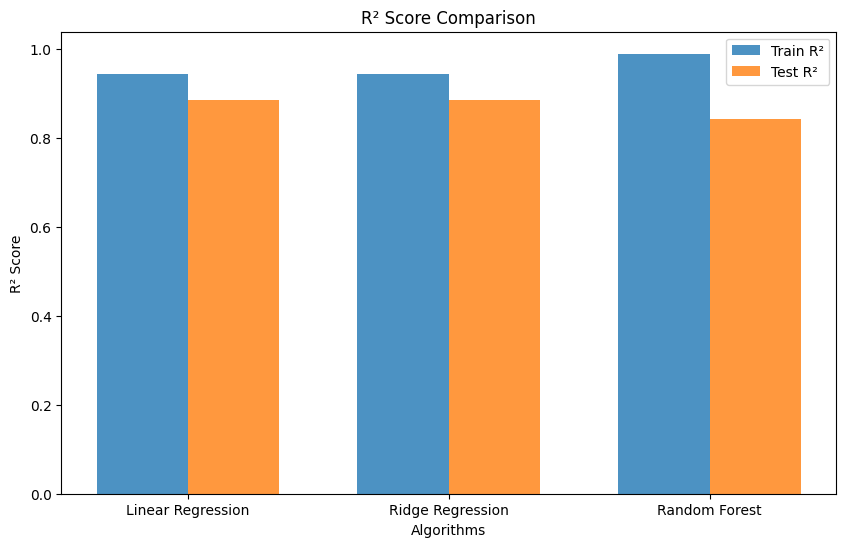

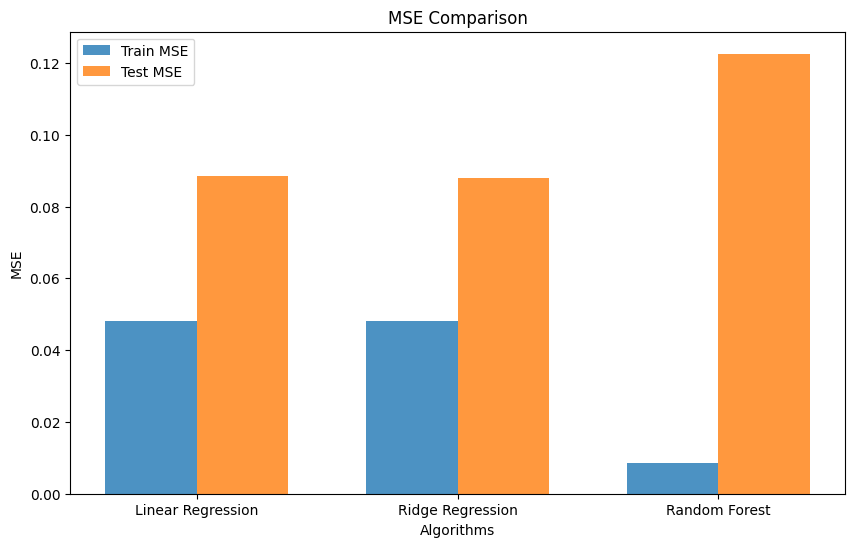

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Performance metrics from the code
algorithms = ["Linear Regression", "Ridge Regression", "Random Forest"]

# R² scores
r2_train = [0.9452837633685566, 0.9452814679743687, 0.9902298689726093]
r2_test = [0.8865257500410954, 0.8869828527823821, 0.8426133073683947]

# MSE values
mse_train = [0.048177572101597434, 0.04817959319306487, 0.008602587111111212]
mse_test = [0.0883909462690662, 0.08803488536662225, 0.12259661286066591]

# R² Score Comparison Bar Chart
x = np.arange(len(algorithms))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, r2_train, width, label='Train R²', alpha=0.8)
bars2 = ax.bar(x + width/2, r2_test, width, label='Test R²', alpha=0.8)

ax.set_xlabel('Algorithms')
ax.set_ylabel('R² Score')
ax.set_title('R² Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()
plt.show()

# MSE Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, mse_train, width, label='Train MSE', alpha=0.8)
bars2 = ax.bar(x + width/2, mse_test, width, label='Test MSE', alpha=0.8)

ax.set_xlabel('Algorithms')
ax.set_ylabel('MSE')
ax.set_title('MSE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()
plt.show()
